In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import cv2
import os
from keras.preprocessing.image import array_to_img , img_to_array, ImageDataGenerator ,load_img
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline


Using TensorFlow backend.


In [0]:
directory='/content/gdrive/My Drive/Colab Notebooks/brain/brain_augmentation'
folders_name=os.listdir(directory)

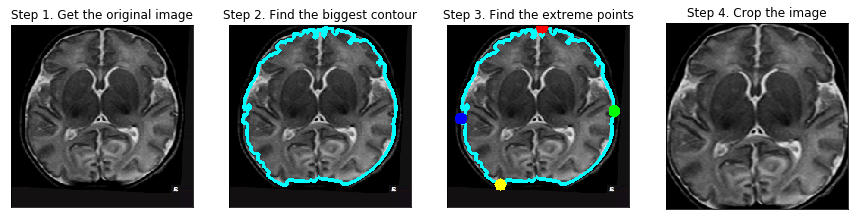

In [0]:
IMG_SIZE=(240,240)
img = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/brain/brain_augmentation/no/No12.jpg29.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        ) 
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]                          # to get a bi_level image,remove noise
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [0]:
def crop_brain_contour(image, plot=False):
   
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [0]:
def load_data(dir_list, image_size):
 

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    count=0
    for directory in dir_list:
      print("-----------------------{}-------------------------".format(directory))
      count=0
      for filename in os.listdir(directory):
          # load the image
          count+=1
          print("{}--------{}".format(filename,count))
          if(count==1500):
            break
          image = cv2.imread(os.path.join(directory,filename))
          # crop the brain and ignore the unnecessary rest part of the image
          image = crop_brain_contour(image, plot=False)
          # resize image
          image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
          # normalize values
          image = image / 255.
          # convert image to numpy array and append it to X
          X.append(image)
          # append a value of 1 to the target array if the image
          # is in the folder named 'yes', otherwise append 0.
          if directory[-3:] == 'yes':
              print(directory[-3:])
              y.append([1])
          else:
              print(directory[-3:])
              y.append([0])
              
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [0]:
augmented_path = '/content/gdrive/My Drive/Colab Notebooks/brain/brain_augmentation/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no],(IMG_WIDTH, IMG_HEIGHT))

-----------------------/content/gdrive/My Drive/Colab Notebooks/brain/brain_augmentation/yes-------------------------
Y52.jpg8.jpg--------1
yes
Y52.jpg9.jpg--------2
yes
Y53.jpg12.jpg--------3
yes
Y53.jpg11.jpg--------4
yes
Y53.jpg10.jpg--------5
yes
Y53.jpg13.jpg--------6
yes
Y53.jpg17.jpg--------7
yes
Y53.jpg16.jpg--------8
yes
Y53.jpg15.jpg--------9
yes
Y53.jpg14.jpg--------10
yes
Y53.jpg2.jpg--------11
yes
Y53.jpg18.jpg--------12
yes
Y53.jpg19.jpg--------13
yes
Y53.jpg20.jpg--------14
yes
Y53.jpg21.jpg--------15
yes
Y53.jpg22.jpg--------16
yes
Y53.jpg4.jpg--------17
yes
Y53.jpg23.jpg--------18
yes
Y53.jpg3.jpg--------19
yes
Y53.jpg6.jpg--------20
yes
Y53.jpg5.jpg--------21
yes
Y53.jpg24.jpg--------22
yes
Y53.jpg8.jpg--------23
yes
Y53.jpg9.jpg--------24
yes
Y53.jpg7.jpg--------25
yes
Y54.jpg0.jpg--------26
yes
Y54.jpg1.jpg--------27
yes
Y54.jpg10.jpg--------28
yes
Y54.jpg11.jpg--------29
yes
Y54.jpg17.jpg--------30
yes
Y54.jpg16.jpg--------31
yes
Y54.jpg12.jpg--------32
yes
Y54.jpg

In [0]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=42,shuffle=True,test_size=0.4)

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()
input_shape=(240,240,3)
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 238, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 119, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 117, 64)      9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
____________________________________

In [0]:
history = model.fit(x=xtrain, y=ytrain,
                    validation_data=(xtest, ytest),
                    batch_size=30,
                    epochs=10,
                    verbose=1)

Train on 1798 samples, validate on 1200 samples
Epoch 1/10
1798/1798 [==============================] - 126s 70ms/step - loss: 0.4179 - acc: 0.8137 - val_loss: 0.2499 - val_acc: 0.9017
Epoch 2/10
1798/1798 [==============================] - 124s 69ms/step - loss: 0.2068 - acc: 0.9238 - val_loss: 0.1179 - val_acc: 0.9592
Epoch 3/10
1798/1798 [==============================] - 124s 69ms/step - loss: 0.1154 - acc: 0.9555 - val_loss: 0.0942 - val_acc: 0.9758
Epoch 4/10
1798/1798 [==============================] - 124s 69ms/step - loss: 0.0461 - acc: 0.9828 - val_loss: 0.1043 - val_acc: 0.9692
Epoch 5/10
1798/1798 [==============================] - 124s 69ms/step - loss: 0.0373 - acc: 0.9861 - val_loss: 0.0637 - val_acc: 0.9800
Epoch 6/10
1798/1798 [==============================] - 125s 69ms/step - loss: 0.0143 - acc: 0.9944 - val_loss: 0.0840 - val_acc: 0.9800
Epoch 7/10
1798/1798 [==============================] - 124s 69ms/step - loss: 0.0409 - acc: 0.9867 - val_loss: 0.0690 - val_acc: 

In [0]:
np.shape(xtest)

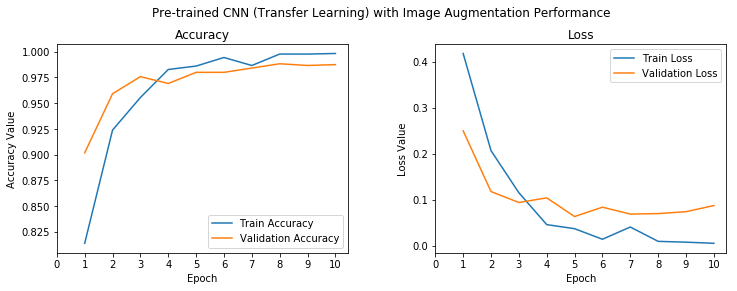

In [0]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/brain/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/brain/model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# load json and create model
json_file = open('/content/gdrive/My Drive/Colab Notebooks/brain/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/Colab Notebooks/brain/model.h5")
print("Loaded model from disk")

model.save('/content/gdrive/My Drive/Colab Notebooks/brain/model.hdf5')
loaded_model=load_model('/content/gdrive/My Drive/Colab Notebooks/brain/model.hdf5')

Loaded model from disk


'{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "batch_input_shape": [null, 240, 240, 3], "dtype": "float32", "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d_1", "trainable": true, "dtype": "float32", "pool_size": [2, 2], "padding": "valid", "strides": [2, 2], "data_format": "channels_last"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": tr

In [0]:
from keras.applications import vgg16
from keras.models import Model
import keras
input_shape=(240,240,3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

58892288/58889256 [==============================] - 1s 0us/step






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
______________________________________________________

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(250, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 25088)             14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 250)               6272250   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 251       
Total params: 21,049,939
Trainable params: 6,335,251
Non-trainable params: 14,714,688
__________________________________

In [0]:
history1 = model.fit(x=xtrain, y=ytrain,
                    validation_data=(xtest, ytest),
                    batch_size=30,
                    epochs=10,
                    verbose=1)



Train on 1798 samples, validate on 1200 samples
Epoch 1/10
1798/1798 [==============================] - 46s 26ms/step - loss: 0.5602 - acc: 0.7047 - val_loss: 0.4063 - val_acc: 0.8350
Epoch 2/10
1798/1798 [==============================] - 36s 20ms/step - loss: 0.3603 - acc: 0.8660 - val_loss: 0.2511 - val_acc: 0.9467
Epoch 3/10
1798/1798 [==============================] - 36s 20ms/step - loss: 0.2451 - acc: 0.9294 - val_loss: 0.1625 - val_acc: 0.9783
Epoch 4/10
1798/1798 [==============================] - 36s 20ms/step - loss: 0.1655 - acc: 0.9672 - val_loss: 0.1068 - val_acc: 0.9917
Epoch 5/10
1798/1798 [==============================] - 36s 20ms/step - loss: 0.1121 - acc: 0.9800 - val_loss: 0.0677 - val_acc: 0.9958
Epoch 6/10
1798/1798 [==============================] - 36s 20ms/step - loss: 0.0765 - acc: 0.9900 - val_loss: 0.0486 - val_acc: 0.9975
Epoch 7/10
1798/1798 [==============================] - 36s 20ms/step - loss: 0.0460 - acc: 0.9967 - val_loss: 0.0398 - val_acc: 0.997

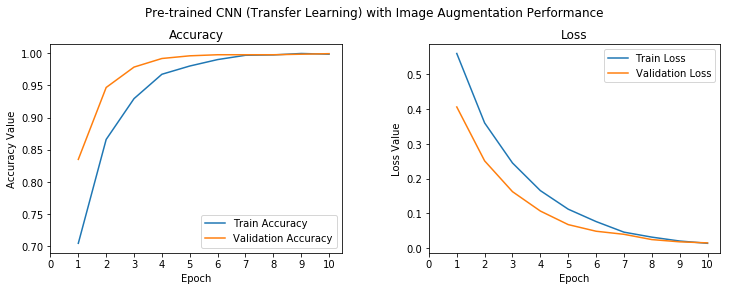

In [0]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history1.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history1.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/brain/vgg16_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/brain/vgg16_model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
json_file = open('/content/gdrive/My Drive/Colab Notebooks/brain/vgg16_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/Colab Notebooks/brain/vgg16model.h5")
print("Loaded model from disk")

model.save('/content/gdrive/My Drive/Colab Notebooks/brain/model.hdf5')
loaded_model=load_model('/content/gdrive/My Drive/Colab Notebooks/brain/model.hdf5')

In [0]:
json_file = open('/content/gdrive/My Drive/Colab Notebooks/brain/vgg16_model.json', 'r')
d=json_file.read()

In [0]:
d.split("{")

['',
 '"class_name": "Sequential", "config": ',
 '"name": "sequential_2", "layers": [',
 '"class_name": "Model", "config": ',
 '"name": "model_1", "layers": [',
 '"name": "input_1", "class_name": "InputLayer", "config": ',
 '"batch_input_shape": [null, 240, 240, 3], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, ',
 '"name": "block1_conv1", "class_name": "Conv2D", "config": ',
 '"name": "block1_conv1", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": ',
 '"class_name": "VarianceScaling", "config": ',
 '"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": ',
 '"class_name": "Zeros", "config": ',
 '}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": n